In [508]:
import os, random, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import dask
from dask.diagnostics import ProgressBar
import caiman as cm
import h5py
# from skimage.external import tifffile as tff
from sklearn.decomposition import PCA
import tifffile as tff
import joblib
import plotly.graph_objects as go
import glob
import seaborn as sns

codeDir = r'V:/code/python/code'
sys.path.append(codeDir)
import apCode.FileTools as ft
import apCode.volTools as volt
from apCode.machineLearning import ml as mlearn
import apCode.behavior.FreeSwimBehavior as fsb
import apCode.behavior.headFixed as hf
import apCode.SignalProcessingTools as spt
import apCode.geom as geom
import importlib
from apCode import util as util
from apCode import hdf
from apCode.imageAnalysis.spim import regress
from apCode.behavior import gmm as my_gmm
from apCode.machineLearning.preprocessing import Scaler
import rsNeuronsProj.util as rsp

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


try:
    if __IPYTHON__:
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

# Setting seed for reproducability
seed = 143
random.seed = seed

print(time.ctime())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Fri Apr 24 18:56:27 2020


### *Read the xls sheet with all the data paths*

In [3]:
#%% Path to excel sheet storing paths to data and other relevant info
dir_xls = r'Y:\Avinash\Projects\RS recruitment\GCaMP imaging'
file_xls = 'GCaMP volumetric imaging summary.xlsx'
xls = pd.read_excel(os.path.join(dir_xls, file_xls), sheet_name='Sheet1')
xls.head()

,Date,Genotype,Session,Time,FishIdx,FishIdxInSession,Path,RoiSet,AllCaImgs,Quality,Comments
0,20191106.0,xa316,0,2300,0,0,Y:\Avinash\Head-fixed tail free\GCaMP imaging\...,0,0.0,1,Poor SNR
1,20191107.0,xa316,0,2200,1,0,Y:\Avinash\Head-fixed tail free\GCaMP imaging\...,0,0.0,?,NaN
2,20191119.0,xa316,0,2200,2,1,Y:\Avinash\Head-fixed tail free\GCaMP imaging\...,0,0.0,?,NaN
3,20191207.0,nefma-alx,0,2400,3,2,Y:\Avinash\Head-fixed tail free\GCaMP imaging\...,0,0.0,?,NaN
4,20191211.0,xa316,0,1800,4,1,Y:\Avinash\Head-fixed tail free\GCaMP imaging\...,0,0.0,?,NaN


### *Behavior variability*

In [4]:
#%% A function for extracting behavior and stim location from paths and putting in dataframe
def get_behav_from_path(path, fishLen=50):
    path_hFile = glob.glob(os.path.join(path, 'procData*.h5'))
    if len(path_hFile)>0:
        path_hFile = path_hFile[-1]
    else:
        print(f'No HDF file in path:\t {path}')
        return None
    with h5py.File(path_hFile, mode='r') as hFile:
        if 'behav' in hFile:
            grp = hFile['behav']
            if ('tailAngles' in grp) & ('stimLoc' in grp):
                ta = np.array(grp['tailAngles'])
                nTrls = ta.shape[0]//fishLen
                ta = ta[:nTrls*fishLen].reshape(nTrls, fishLen,-1)
                stimLoc = util.to_utf(grp['stimLoc'])
                trlNum = np.arange(nTrls)
                dic = dict(trlNum=trlNum, tailAngles=list(ta), stim=stimLoc, path=[path_hFile]*nTrls)
            else:
                dic = None
        else:
            dic=None
    if dic is not None:
        dic = pd.DataFrame(dic)
    return dic

### _Extract tail angles from all datasets where behavior's been extracted already_

In [7]:
%%time
fishInds = np.unique(xls.FishIdx)
dataFrame_behav = []
for iFish, idx_fish in enumerate(fishInds):
    print(f'Fish # {iFish}/{len(fishInds)}')
    path_ = xls.loc[xls.FishIdx==idx_fish].Path.iloc[0]
    df_ = get_behav_from_path(path_)
    if df_ is not None:
        df_ = df_.assign(fishIdx=idx_fish)
        dataFrame_behav.append(df_)
dataFrame_behav = pd.concat(dataFrame_behav, axis=0, ignore_index=True)

Fish # 0/13
Fish # 1/13
Fish # 2/13
No HDF file in path:	 Y:\Avinash\Head-fixed tail free\GCaMP imaging\2019-11-19\f2
Fish # 3/13
Fish # 4/13
Fish # 5/13
Fish # 6/13
Fish # 7/13
Fish # 8/13
Fish # 9/13
Fish # 10/13
Fish # 11/13
Fish # 12/13
Wall time: 4.77 s


### _Clean tail angles using SVD_

In [20]:
%%time
#%% Clean tail angles using SVD
trlLens = np.array([_.shape[-1] for _ in dataFrame_behav.tailAngles])
trlLen = trlLens.min()
ta = np.array([np.array(_)[:,:trlLen] for _ in np.array(dataFrame_behav.tailAngles)])
nTrls = ta.shape[0]
ta_ser = np.concatenate(ta, axis=1)
# Clean tailAngles
%time ta_clean, _, svd = hf.cleanTailAngles(ta_ser)
ta_trl = np.array(np.hsplit(ta_clean, nTrls))
dataFrame_behav = dataFrame_behav.assign(tailAngles = list(ta_trl))

Wall time: 52.4 s
Wall time: 53.5 s


### *Re-fit the gmm_model with updated dataset, if need be*

In [28]:
%time gmm_model = gmm_model.fit(ta_clean)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
Initialization converged: True
Wall time: 8min 12s


### *Save the GMM model*

In [65]:
dir_group = r'Y:\Avinash\Projects\RS recruitment\GCaMP imaging\Group'
fn = f'gmm_for_headFixed_[{gmm_model.n_gmm_}]_svd_[{gmm_model.n_svd_}]' 
fn = fn + f'_env_pca_[{gmm_model.pca.n_components_}]_{util.timestamp()}.pkl'

dir_save = os.path.join(dir_group, f'session_{util.timestamp()}')
os.makedirs(dir_save, exist_ok=True)

%time path_gmm = joblib.dump(gmm_model, os.path.join(dir_save, fn))[0]
print(path_gmm)

Wall time: 14.1 ms
Y:\Avinash\Projects\RS recruitment\GCaMP imaging\Group\session_20200424-03\gmm_for_headFixed_[20]_svd_[3]_env_pca_[8]_20200424-03.pkl


### _Load pre-trained GM model and predict on all the behavrior trials_

In [22]:
#%% Load the trained model
gmm_model = joblib.load(path_gmm)

In [66]:
%%time
labels = []
for ta_ in ta_trl:
    lbls = gmm_model.predict(ta_)[0]
    labels.append(lbls)
dataFrame_behav = dataFrame_behav.assign(gmmLabels=labels)

Wall time: 5.93 s


### *Save the dataframe*

In [70]:
fn = 'dataFrame_headFixed_tailAngles_gmmLabels.pkl'
%time dataFrame_behav.to_pickle(os.path.join(dir_save, fn))

Wall time: 2.36 s


### *Compute $p(l_i|t_j)$, where $l_m {\in} \{l_i\}_{i=0}^{m}$ and $t_j {\in} \{t_j\}_{j=1}^{n}$*

In [422]:
bw = 0.5 # bandwith in ms
Fs_behav=500
from sklearn.neighbors import KernelDensity

ta_tot = np.array([_[-1] for _ in dataFrame_behav.tailAngles])
lbls_trl = np.array([_ for _ in dataFrame_behav.gmmLabels])
lbls_unique = np.unique(lbls_trl.flatten())

# Get the indices of each of the labels across all trials
lbls_inds = []
for lbl_ in lbls_unique:
    inds_ = np.where(lbls_trl == lbl_)[1] # Only the column inds because we want to average over time
    lbls_inds.append(inds_)

# bandwidth = int(np.round(bw*Fs_behav))
tt = np.arange(ta_tot.shape[1])
kde = KernelDensity(kernel='exponential', bandwidth=bw)
func_now = lambda x: kde.fit(x[:, None]).score_samples(tt[:, None])
with ProgressBar():
    lbls_log_prob = dask.compute(*[dask.delayed(func_now)(inds_) for inds_ in lbls_inds])
lbls_log_prob = np.array(lbls_log_prob)
lbls_prob = np.array([np.exp(lp) for lp in lbls_log_prob])
S = lbls_prob.sum(axis=0)[None, :]
lbls_prob_norm = lbls_prob/S

# Centers of mass for each labels probability distribution over time
coms = []
for p in lbls_prob_norm:    
    coms.append(np.argmax(p))    
coms = np.array(coms)


[########################################] | 100% Completed |  1min 52.9s


### *Plot the label probabilities over time*

Figure saved at Y:\Avinash\Projects\RS recruitment\GCaMP imaging\Group\session_20200424-03


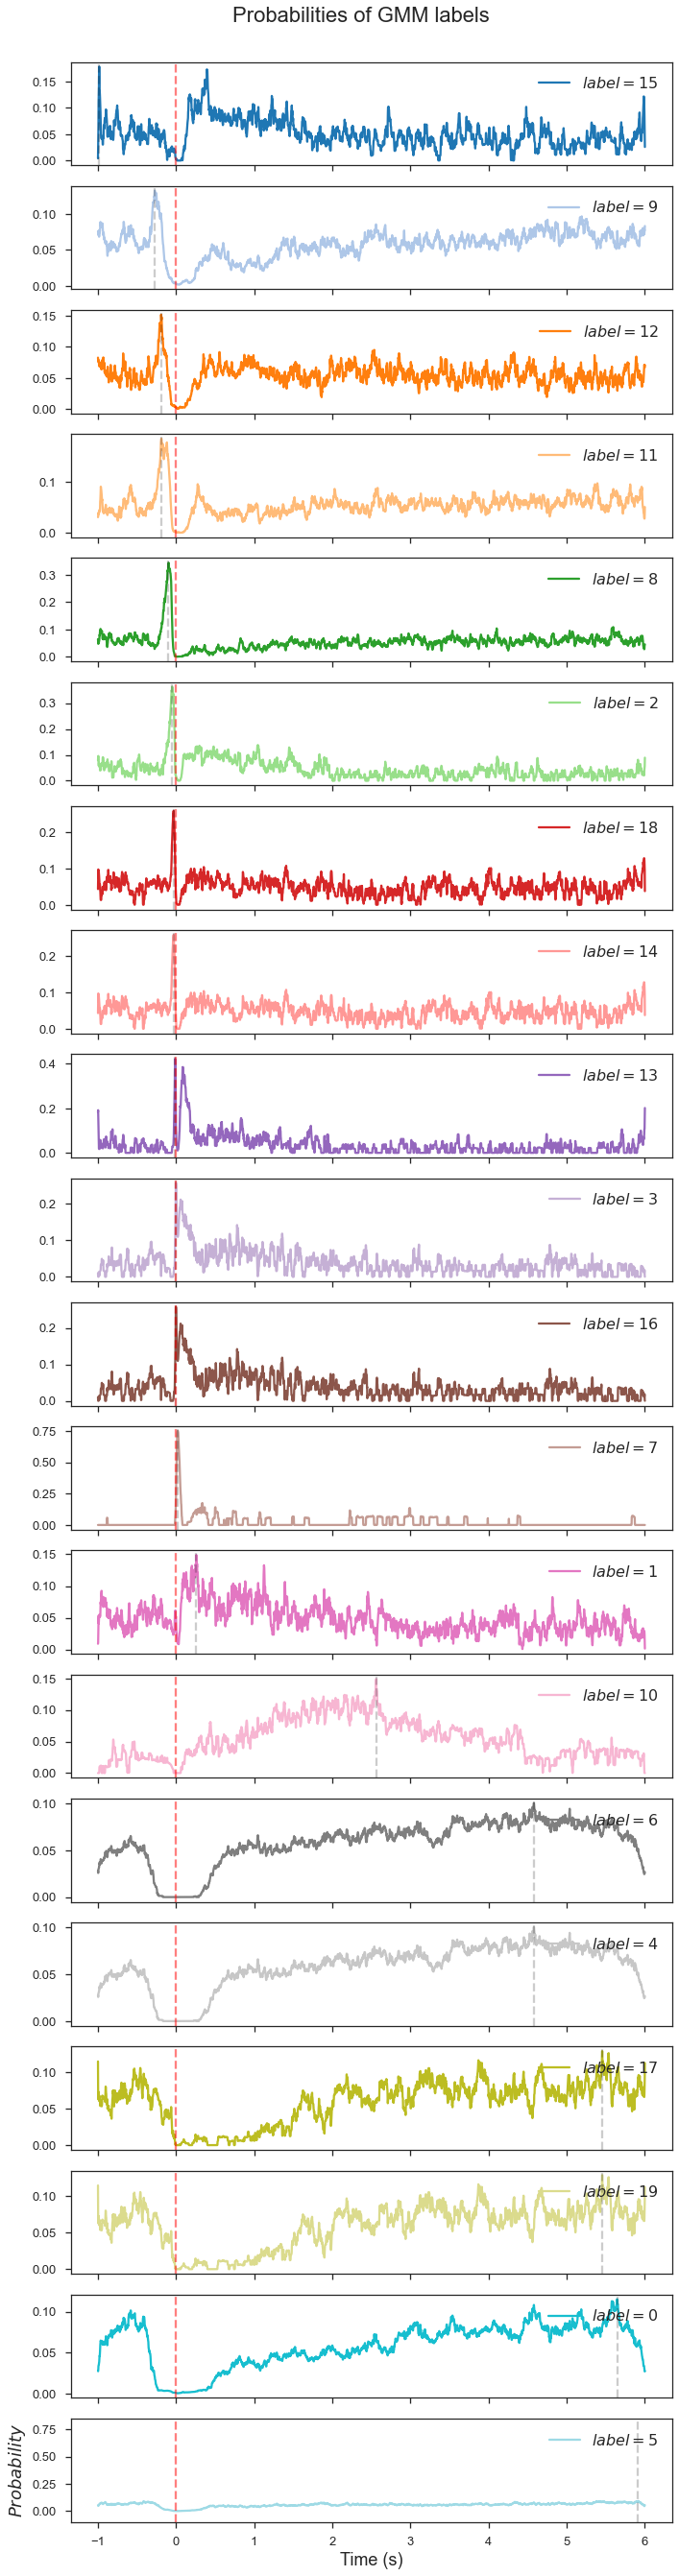

In [580]:
nPreStim=499
Fs_behav=500
xl = (-0.1, 0.5)
fn = f'Fig-{util.timestamp()}_GMM label probabilities over trial time_bw[{bw}]_notNorm'

inds_sort_pkTime = np.argsort(coms)
plt.style.use(('seaborn-darkgrid', 'seaborn-talk', 'seaborn-ticks'))
t_now = (tt-nPreStim)*(1/Fs_behav)
coms_t = (coms-nPreStim)*(1/Fs_behav)
nLbls = len(lbls_unique)
X = lbls_prob_norm[inds_sort_pkTime]
yl = (-0.1, lbls_prob_norm.max()+0.1)
clrMap = plt.cm.tab20(spt.standardize(np.arange(nLbls)))
fh, ax = plt.subplots(nLbls, 1, figsize=(10, 2*nLbls), sharex=True, sharey=False)
for iLbl, ax_ in enumerate(ax):
    ax_.plot(t_now, X[iLbl], c= clrMap[iLbl], label=f'$label={inds_sort_pkTime[iLbl]}$')      
    ax_.legend(loc='upper right', fontsize=16)
    ax_.axvline(coms_t[inds_sort_pkTime[iLbl]], color='k', ls='--', alpha=0.2)
    ax_.axvline(0, color='r', ls='--', alpha=0.5)
# ax_.set_xlim(xl)
ax_.set_ylim(yl)
ax_.set_xlabel('Time (s)', fontsize=18)
ax_.set_ylabel('$Probability$', fontsize=18)
fh.suptitle('Probabilities of GMM labels', fontsize=22)
fh.subplots_adjust(top=0.96)
fh.savefig(os.path.join(dir_save, fn + '.png'), dpi='figure')
fh.savefig(os.path.join(dir_save, fn + '.pdf'), dpi='figure')
print(f'Figure saved at {dir_save}')

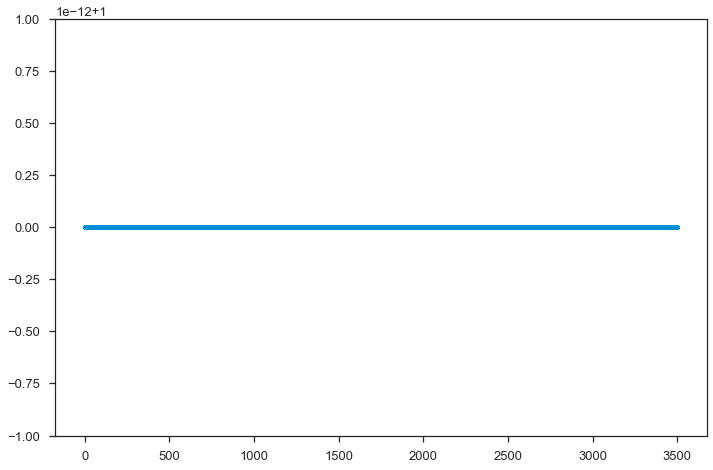

In [579]:
plt.plot(lbls_prob_norm.sum(axis=0),'.')
plt.savefig(os.path.join(dir_save, 'probSumOverTime.png'))

Figure saved at Y:\Avinash\Projects\RS recruitment\GCaMP imaging\Group\session_20200424-03


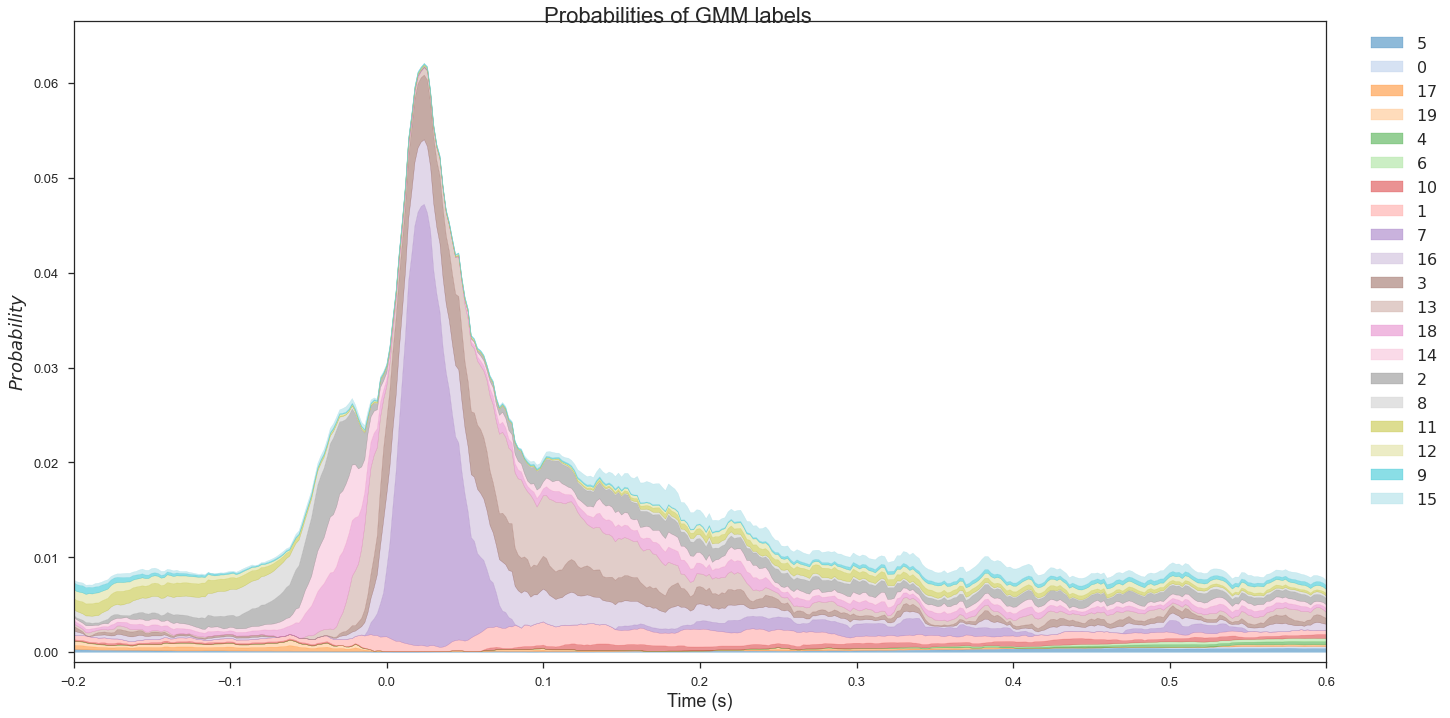

In [568]:
nPreStim=499
Fs_behav=500
xl = (-0.2, 0.6)
fn = f'Fig-{util.timestamp()}_GMM label probabilities over trial time_ordered by prob peak time_bw[{bw}]'

inds_sort_pkTime = np.argsort(-coms)
plt.style.use(('seaborn-ticks', 'seaborn-talk'))
t_now = (tt-nPreStim)*(1/Fs_behav)
coms_t = (coms-nPreStim)*(1/Fs_behav)
nLbls = len(lbls_unique)
X = lbls_prob[inds_sort_pkTime]
clrMap = plt.cm.tab20(spt.standardize(np.arange(nLbls)))

fh = plt.figure(figsize=(20, 10))
for iLbl, x in enumerate(X):
    if iLbl==0:
        x_prev = 0
        x_now = x
    else:
        x_prev = x_now
        x_now = x_prev + x
    plt.fill_between(t_now, x_prev, x_now, color = clrMap[iLbl],
                     label=f'${inds_sort_pkTime[iLbl]}$', alpha=0.5)      
plt.legend(loc='upper right', fontsize=16, bbox_to_anchor=(1.1, 1))
plt.xlim(xl)
plt.ylim(-0.001, X.max()+0.02)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('$Probability$', fontsize=18)
plt.suptitle('Probabilities of GMM labels', fontsize=22)
plt.subplots_adjust(top=0.96)
fh.savefig(os.path.join(dir_save, fn + '.png'), dpi='figure')
fh.savefig(os.path.join(dir_save, fn + '.pdf'), dpi='figure')
print(f'Figure saved at {dir_save}')

### *Compute label probabilities separately for head and tail trials for comparison*

In [240]:
# Get the indices of each of the labels across all trials
stims = np.array([_[-1] for _ in dataFrame_behav.stim])
trls_head = np.where(stims=='h')[0]
trls_tail = np.where(stims=='t')[0]

lbls_inds_head, lbls_inds_tail = [], []
for lbl_ in lbls_unique:
    inds_ = np.where(lbls_trl[trls_head] == lbl_)[1] # Only the column inds because we want to average over time
    lbls_inds_head.append(inds_)
    inds_ = np.where(lbls_trl[trls_tail]==lbl_)[1]
    lbls_inds_tail.append(inds_)

# bandwidth = int(np.round(bw*Fs_behav))
tt = np.arange(ta_tot.shape[1])
kde = KernelDensity(kernel='exponential', bandwidth=bw)
func_now = lambda x: kde.fit(x[:, None]).score_samples(tt[:, None])
with ProgressBar():
    lbls_log_prob_head = dask.compute(*[dask.delayed(func_now)(inds_) for inds_ in lbls_inds_head])

with ProgressBar():
    lbls_log_prob_tail = dask.compute(*[dask.delayed(func_now)(inds_) for inds_ in lbls_inds_tail])
lbls_log_prob_head = np.array(lbls_log_prob_head)
lbls_log_prob_tail = np.array(lbls_log_prob_tail)
lbls_prob_head = np.array([np.exp(lp) for lp in lbls_log_prob_head])
lbls_prob_tail = np.array([np.exp(lp) for lp in lbls_log_prob_tail])
S_head = lbls_prob_head.sum(axis=0)[None, :]
S_tail = lbls_prob_tail.sum(axis=0)[None, :]
lbls_prob_norm_head = lbls_prob_head/S_head
lbls_prob_norm_tail = lbls_prob_tail/S_tail

[########################################] | 100% Completed |  1min 18.3s
[########################################] | 100% Completed | 55.3s


### *Plot the label probabilities over time separately for head and tail trials*

Figure saved at Y:\Avinash\Projects\RS recruitment\GCaMP imaging\Group\session_20200424-03


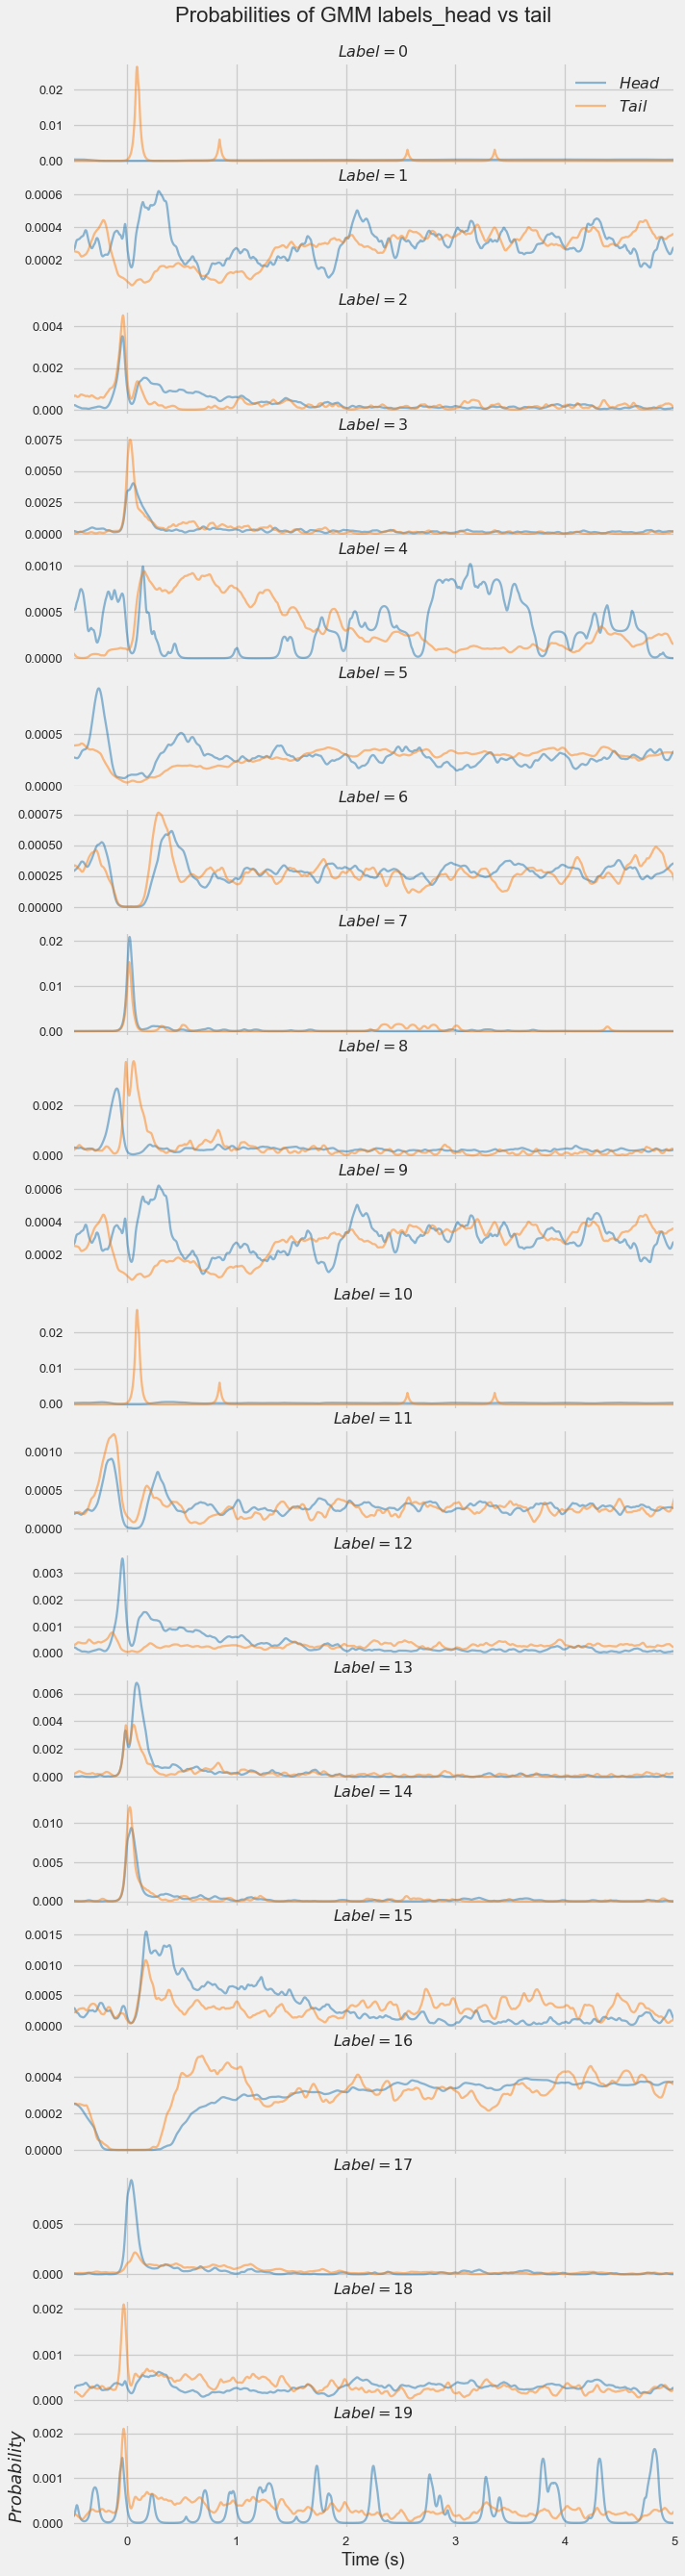

In [562]:
fn = f'Fig-{util.timestamp()}_GMM label probabilities over trial time_head and tail trls separated'

plt.style.use(('seaborn-white', 'fivethirtyeight', 'seaborn-talk'))
t_now = (tt-499)*(1/500)

nLbls = len(lbls_unique)
fh, ax = plt.subplots(nLbls, 1, figsize=(10, 2*nLbls), sharex=True, sharey=False)
for iLbl, ax_ in enumerate(ax):
    if iLbl ==0:
        ax_.plot(t_now, lbls_prob_head[iLbl], c= plt.cm.tab10(0), label=f'$Head$', alpha=0.5)
        ax_.plot(t_now, lbls_prob_tail[iLbl], c= plt.cm.tab10(1), label=f'$Tail$', alpha=0.5)
        ax_.legend(loc='upper right', fontsize=16)
    else:
        ax_.plot(t_now, lbls_prob_head[iLbl], c= plt.cm.tab10(0), alpha=0.5)
        ax_.plot(t_now, lbls_prob_tail[iLbl], c= plt.cm.tab10(1), alpha=0.5)
    ax_.set_title(f'$Label = {iLbl}$', fontsize=16)
ax_.set_xlim(-0.5, 5)
# ax_.set_ylim(-0.1, lbls_prob_head.max()+0.1)
ax_.set_xlabel('Time (s)', fontsize=18)
ax_.set_ylabel('$Probability$', fontsize=18)
fh.suptitle('Probabilities of GMM labels_head vs tail', fontsize=22)
fh.subplots_adjust(top=0.96)
# fh.savefig(os.path.join(dir_save, fn + '.png'), dpi='figure')
# fh.savefig(os.path.join(dir_save, fn + '.pdf'), dpi='figure')
print(f'Figure saved at {dir_save}')

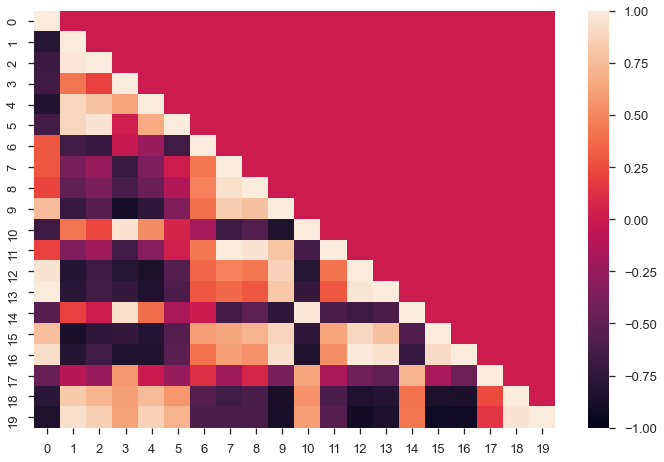

In [585]:
gmm_means = gmm_model.gmm.means_
gmm_cov = gmm_model.gmm.covariances_
similarity_means = np.corrcoef(gmm_means[inds_sort_pkTime])
sim = np.argpartition(similarity_means, 2)
# inds_sort_means = np.argsort(similarity_means, axis=1)
tril = np.tril(similarity_means)
sns.heatmap(tril, vmin=-1, vmax=1)
# sns.heatmap(similarity_means)

In [581]:
inds_sort_means

array([[19,  4,  1, 18,  2, 10,  3,  5, 14, 17, 11,  8,  7,  6,  9, 15,
        16, 12, 13,  0],
       [15, 12, 16,  0, 13,  9,  6,  8,  7, 11, 17, 14, 10,  3, 18,  5,
         4, 19,  2,  1],
       [15,  6,  0, 12, 16, 13,  9,  8,  7, 17, 11, 14,  3, 10, 18,  4,
        19,  5,  1,  2],
       [ 9, 16, 12, 13, 15,  7,  0, 11,  8,  6,  5,  2,  1, 17, 18, 19,
         4, 14, 10,  3],
       [12, 16,  0, 13, 15,  9,  8,  7, 11,  6, 17, 14, 10,  3,  5, 18,
         2, 19,  1,  4],
       [ 6,  0, 13, 15, 12, 16,  9, 17, 14,  8,  7,  3, 11, 10, 18,  4,
        19,  1,  2,  5],
       [ 2,  5,  1, 19, 18,  4, 10,  3, 14, 17, 13,  0, 12,  9, 16,  7,
        11,  8, 15,  6],
       [ 3, 10, 18, 14, 19,  1,  4,  2, 17,  5,  0, 13,  6, 12, 16, 15,
         9,  8, 11,  7],
       [ 3, 19, 18, 10, 14,  1,  4,  2,  5, 17,  0, 13, 12,  6, 16, 15,
         9,  7, 11,  8],
       [ 3, 19, 18, 10, 14,  4,  1,  2, 17,  5,  6,  0,  8, 11, 13,  7,
        12, 15, 16,  9],
       [ 9, 16, 12, 15, 13,  0

### *Interactive HTML plots with plotly*

In [542]:
#%% Check ouf a few trials with predictions from the GMM with annotated markers

# iTrl = 10  # (Struggles = {9, 11}
# iTrl = np.random.choice(np.arange(df.shape[0]),size = 1)[0]
yShift = 1.1
loop = False
xl = (-0.1, 2)
# xl = 'auto'
figDir = os.path.join(dir_save, 'interactiveFigs')
onOffThr = 0
figExts = ('png','pdf')
cmap = plt.cm.tab20
dt_behav = 1/500
pre_behav = 500
figSize = (100, 10)


ta_trl = np.array([np.array(_) for _ in dataFrame_behav.tailAngles])

if not os.path.exists(figDir):
    os.mkdir(figDir)
    
scaler_clrs = Scaler(standardize =True).fit(np.arange(gmm_model.n_gmm_))   

trls = np.arange(ta_trl.shape[0])    
# maxEnv_full = spt.emd.envelopesAndImf(ta[-1])['env']['max']

trls = [70, 71, 73, 74, 75]
for iTrl in trls:
    ta_now = ta_trl[iTrl]
    x = (np.arange(ta_now.shape[1])-499)*dt_behav
    y = ta_now[-1]
    y = y-y[0]
    lbls, _ = gmm_model.predict(ta_now)
    line = go.Scatter(x=x, y = y, mode='lines', opacity = 0.2, marker = dict(color='black'), name='ta')
    scatters = []
    scatters.append(line)
    for iLbl, lbl in enumerate(np.unique(lbls)):
        clr = f'rgba{cmap(lbl)}'
        inds= np.where(lbls==lbl)[0]
        scatter = go.Scatter(x=x[inds], y=y[inds], mode='markers', marker=dict(color=clr, symbol=lbl, size=10),
                             name = f'Lbl-{lbl}')
        scatters.append(scatter)
    fig = go.Figure(scatters)
    fig.update_layout(title = f'Tail angles with GMM labels, trl = {iTrl}, stim = {(stims[iTrl]).upper()}')
#     fig.show()
    figName = f'Fig-{util.timestamp()}_trl-{iTrl}.html'
    fig.write_html(os.path.join(figDir,figName))
print(figDir)


Y:\Avinash\Projects\RS recruitment\GCaMP imaging\Group\session_20200424-03\interactiveFigs


In [545]:
#%% Plot GMM labels --> Markers map
x = np.arange(gmm_model.n_gmm_)
y = np.ones_like(x)
scatters = []
for ind, x_ in enumerate(x):
    clr = f'rgba{cmap(x_)}'
    scatter = go.Scatter(x= [x_], y = [y[ind]], mode = 'markers',
                         marker = dict(symbol = x_, size = 20, color = clr), name = f'Lbl-{x_}')
    scatters.append(scatter)
fig = go.Figure(scatters)
fig.update_xaxes(tickvals = x)
fig.update_yaxes(tickvals = [])
fig.update_layout(title='Symbol map: GMM labels to markers and colors', xaxis_title="GMM label")
fig.show()
# figName = f'Fig-{util.timestamp()}_scatterPlotMarkerGmmLabelLegend.html'
# fig.write_html(os.path.join(figDir,figName), auto_open=False)

In [851]:
lbls_of_interest = [18, 14, 1, 6, 11, 19, 15, 8]
lbl_names = ['Fast-large_struggle', 'Fast-large-escape', 'Medium slow',
             'Medium slow', 'Medium slow', 'Slow', 'Slow', 'Flicks']
tKer = 50e-3

labels=np.array(labels)
likelihood_swim = np.log2(np.abs(ta[:,-1,:]).mean(axis=0))
impulses_lbls = []
for lbl in lbls_of_interest:
    foo = np.zeros_like(labels)
    foo[np.where(labels==lbl)]=1
    impulses_lbls.append(foo)
impulses_lbls = np.array(impulses_lbls)
stimLoc = np.array(dataFrame_behav.stim)
trls_head = np.where(stimLoc=='h')[0]
trls_tail = np.where(stimLoc=='t')[0]

impulses_lbls_head = impulses_lbls[:, trls_head]
impulses_lbls_tail = impulses_lbls[:, trls_tail]
foo_head = impulses_lbls_head.sum(axis=1)
foo_tail = impulses_lbls_tail.sum(axis=1)
nKer = int(tKer*500)
P_head, P_tail = [], [] 
for lbl in foo_head:
    lbl_conv = spt.causalConvWithSemiGauss1d(lbl, nKer)
    P_head.append(lbl_conv)
    
for lbl in foo_tail:
    lbl_conv = spt.causalConvWithSemiGauss1d(lbl, nKer)
    P_tail.append(lbl_conv)

P_head, P_tail = np.array(P_head), np.array(P_tail)
tot = P_head.sum() + P_tail.sum()
P_head /= trls_head.shape[0]
P_tail /= trls_tail.shape[0]

(0.0, 3500.0)

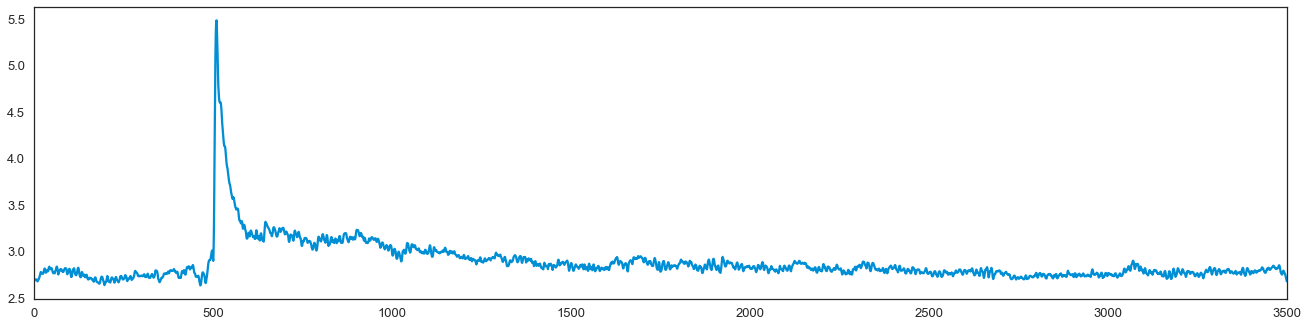

In [839]:
plt.figure(figsize=(20, 5))
plt.plot(likelihood_swim)
plt.xlim(0, len(likelihood_swim))

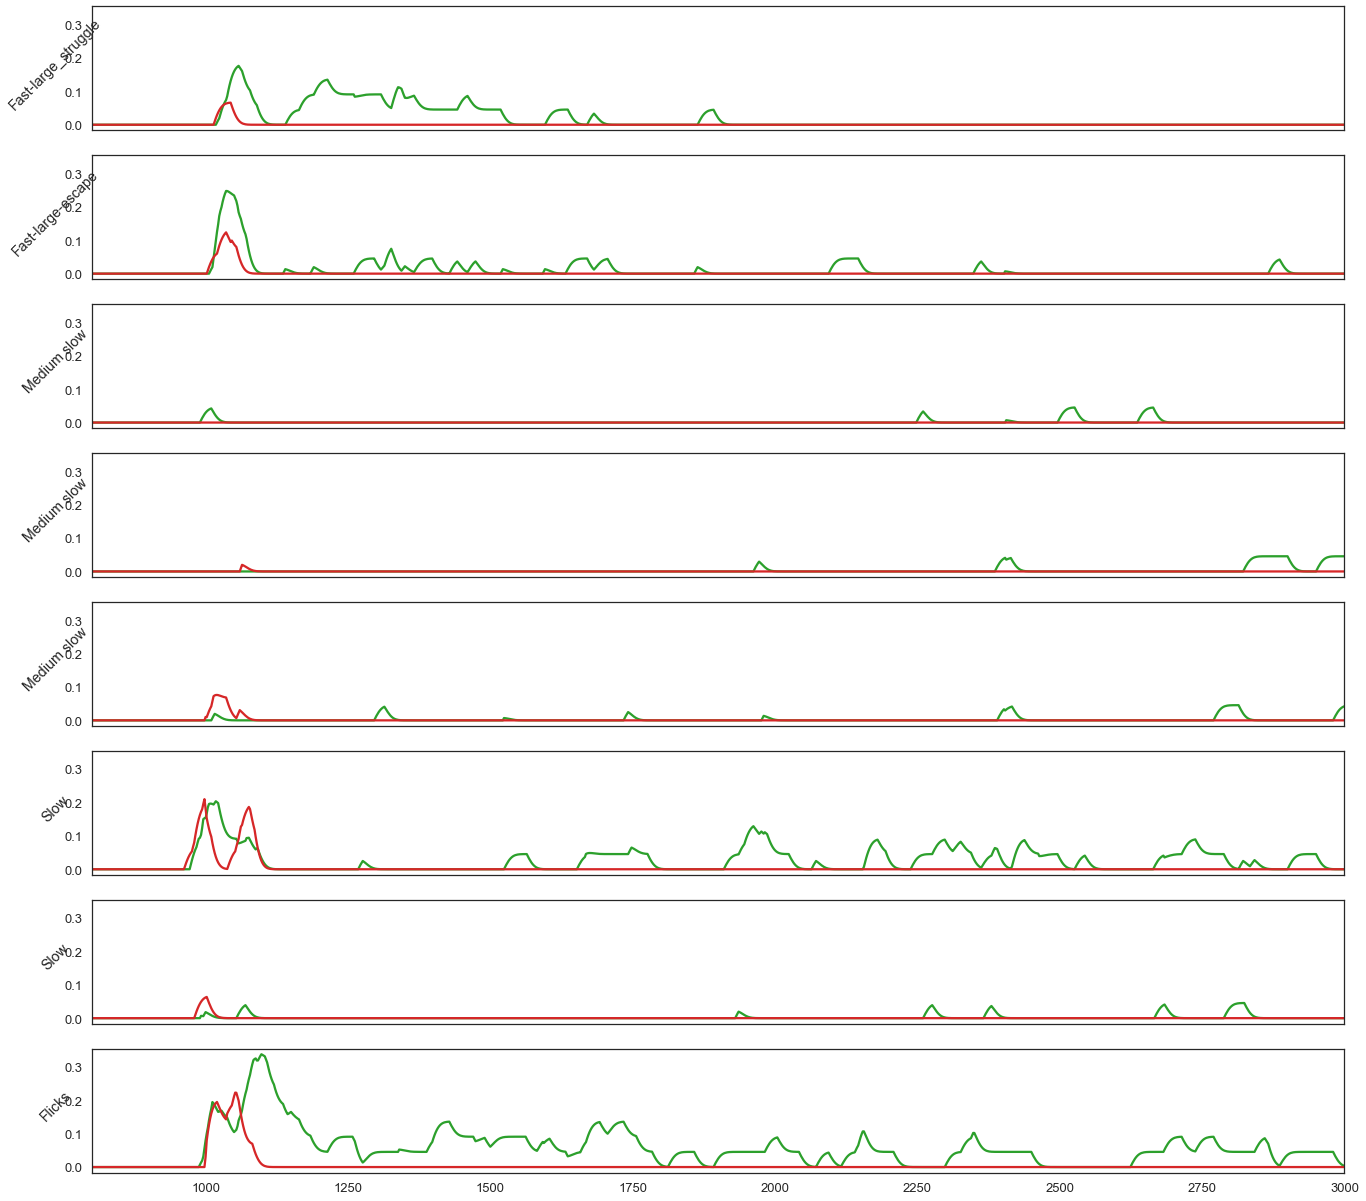

In [853]:
x = np.arange(P_head.shape[1])*(1/500)*1000
fh, ax = plt.subplots(P_head.shape[0],1, figsize=(20, 20), sharex=True, sharey=True)
count = 0
for head, tail in zip(P_head, P_tail):
#     ax[count].plot(x, np.log2(head+1e-6), c=plt.cm.tab10(0))
#     ax[count].plot(x, np.log2(tail+1e-6), c=plt.cm.tab10(1))
    ax[count].plot(x, head, c=plt.cm.tab10(2))
    ax[count].plot(x, tail, c=plt.cm.tab10(3))
#     ax[count].set_ylabel(f'Label # {lbls_of_interest[count]}')
    ax[count].set_ylabel(f'{lbl_names[count]}', rotation=45)
    count +=1
ax[count-1].set_xlim(800, 3000);